<a href="https://colab.research.google.com/github/stephenbeckr/convex-optimization-class/blob/master/Homeworks/HW10/listen_to_Handel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 9/10 test file
For [Homework 9/10](https://github.com/stephenbeckr/convex-optimization-class/tree/master/Homeworks) for APPM 5360, Spring 2021, CU Boulder, Prof. Becker

This file plays the sound, and tests that the utility functions work

In [1]:
# Get needed files from github website
!wget -nv 'https://github.com/stephenbeckr/convex-optimization-class/raw/master/Homeworks/HW10/handel.pkl'
# Load with: y,Fs = pickle.load(open('handel.pkl', 'rb'))
!wget -nv 'https://github.com/stephenbeckr/convex-optimization-class/raw/master/Homeworks/HW10/python_functions.py'

2021-03-22 03:41:34 URL:https://raw.githubusercontent.com/stephenbeckr/convex-optimization-class/master/Homeworks/HW10/handel.pkl [585153/585153] -> "handel.pkl" [1]
2021-03-22 03:41:34 URL:https://raw.githubusercontent.com/stephenbeckr/convex-optimization-class/master/Homeworks/HW10/python_functions.py [4662/4662] -> "python_functions.py" [1]


In [26]:
import numpy as np
from numpy.linalg import norm
import scipy, scipy.io
import pickle
import scipy.signal as sig
import matplotlib.pyplot as plt
from IPython.display import Audio

from python_functions import * # HW10 pre-made functions

# Convert to decibels (dB)
dbPower = lambda f : 10*np.log10(np.abs(f))
dbAmplitude = lambda f : 20*np.log10(np.abs(f))

# Play the sound clip
We'll downsample it, and also downsample with filtering

In [3]:
y,Fs = pickle.load(open('handel.pkl', 'rb'))
y = y.ravel() # want a vector, not (n,1) array
Fs = Fs[0][0] # want a scalar, not a (1,1) array
Fs = float(Fs)

print("Original audio clip")
Audio(y,rate=Fs)

Original audio clip


#### Now if we downsample by factor of 2

In [4]:
print("Downsampled by factor of 2")
Audio(y[::2],rate=Fs/2)

Downsampled by factor of 2


Anti-alias (lowpass) filter then downsample

Use Parks-McClellan to design a lowpass filter with:
- a passband from 0*Nyquist to 0.25*Nyquist
- a stopband from 0.3*Nyquist to 0.5*Nyquist

In [5]:
filt = sig.remez(100, [0, 0.125, 0.15, 0.5], [1, 0])
lowpassFilter = lambda y : sig.lfilter(filt, np.array([1]), y)

print("Filtered, then downsampled by factor of 2")
Audio( lowpassFilter(y)[::2], rate=Fs/2)

Filtered, then downsampled by factor of 2


#### Now if we downsample by factor of 4

In [6]:
print("Downsampled by factor of 4")

# Audio(y[::4],rate=Fs/4) 
# Chrome won't play below 3kHz, https://github.com/jupyter/notebook/issues/4321#issuecomment-536264680
# Instead, we'll upsample it back to Fs/2, but setting higher frequencies to zero explicitly
def trigonometricInterpolation(f):
  """ upsamples by a factor of 2 """
  F = np.fft.rfft(f.ravel())
  F = np.concatenate( (F, np.zeros(F.size)) )
  return np.fft.irfft(F)

y4 = trigonometricInterpolation(y[::4])
Audio(y4,rate=Fs/2) 

Downsampled by factor of 4


In [7]:
print("Filtered, then downsampled by factor of 4")
y4 = trigonometricInterpolation(lowpassFilter(y)[::4])
Audio( y4, rate=Fs/2)

Filtered, then downsampled by factor of 4


# Plot spectrograms and periodograms

#### The filter we use

Text(0.5, 0, 'Frequency [Hz]')

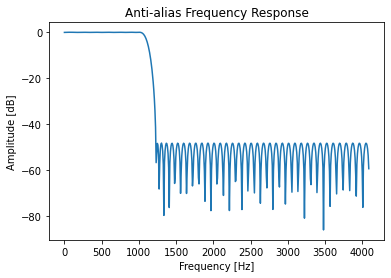

In [71]:
w, h = sig.freqz(filt)
fig = plt.figure()
plt.title('Anti-alias Frequency Response')
plt.plot(w/np.pi*Fs/2, dbAmplitude(h) )
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [Hz]')

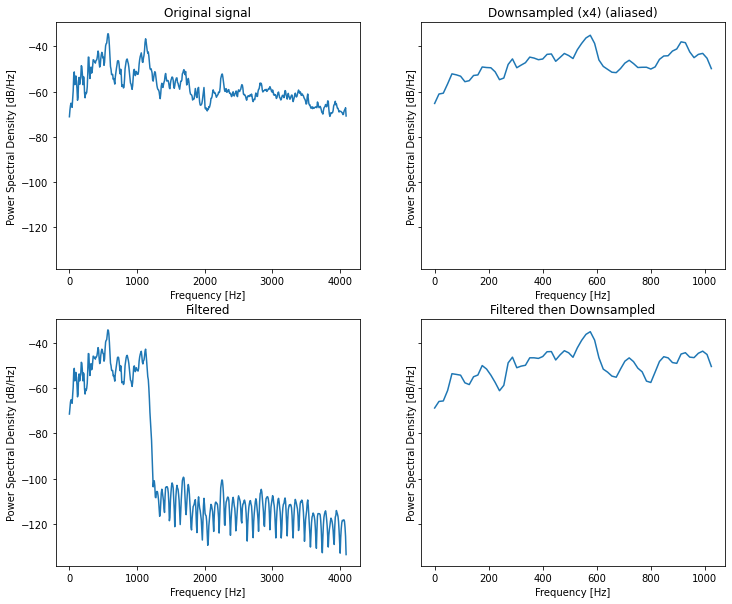

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,10),sharey=True)

# def with_logging(*args, **kwargs):
#     print(func.__name__ + " was called")
#     return func(*args, **kwargs)
def periodogram(*args,**kwargs):
  return sig.welch(*args,**kwargs,window='barthann',scaling='density')

f, Pxx = periodogram(y,fs=Fs,nperseg=1024)
ax1.plot(f, dbPower(Pxx))
ax1.set_title('Original signal')

f, Pxx = periodogram(y[::4], fs=Fs/4, nperseg=128)
ax2.plot(f, dbPower(Pxx))
ax2.set_title('Downsampled (x4) (aliased)')

f, Pxx = periodogram(lowpassFilter(y), fs=Fs, nperseg=1024)
ax3.plot(f, dbPower(Pxx))
ax3.set_title('Filtered')

f, Pxx = periodogram(lowpassFilter(y)[::4], fs=Fs/4, nperseg=128)
ax4.plot(f, dbPower(Pxx))
ax4.set_title('Filtered then Downsampled')

for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Power Spectral Density [dB/Hz]')
plt.show()

#### Periodogram
Can you you see the two slow "Hallelujah"s followed by the four fast "Halleluyah"s?

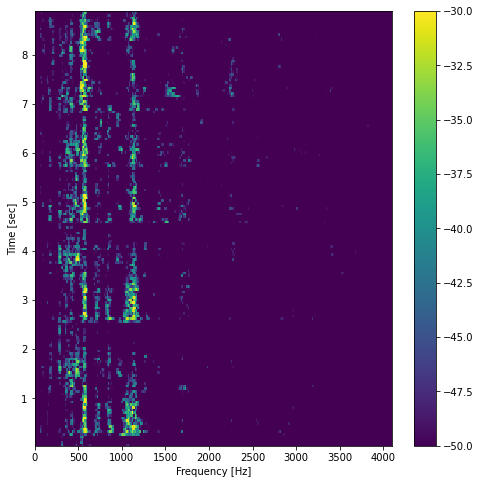

In [22]:
fig = plt.figure(figsize=(8,8))
f, t, Sxx = sig.spectrogram(y, fs=Fs, window='barthann', nperseg=512,
    scaling='density')
plt.pcolormesh(f, t, dbPower(Sxx.T), vmin=-50,vmax=-30)
plt.colorbar()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Time [sec]')
plt.show()

# Test the utility functions
from `python_functions.py`

#### Test the l1 projection function

In [46]:
# ?project_l1

rng   = np.random.default_rng()
x     = rng.normal(size=(100,1))
print('l1 norm of x is',norm(x,1))

# Test 1: projection shouldn't do anything
tau   = norm(x,1)*1.1
y     = project_l1( x, tau )
print(f"Test 1, error is {norm(y-x):.2e}")

# Test 2: projection should do something
tau   = norm(x,1)*0.8
import cvxpy as cvx
y     = cvx.Variable(x.shape)
obj   = cvx.Minimize( cvx.norm(y-x) )
constraints = [ cvx.norm(y,1) <= tau]
prob  = cvx.Problem(obj,constraints)
prob.solve(verbose=False,solver='ECOS',abstol=1e-15,reltol=1e-15,feastol=1e-15)

yy    = project_l1(x,tau)
print(f"Test 2, error is {norm(yy-y.value):.2e}")

l1 norm of x is 79.02803776299314
Test 1, error is 0.00e+00
Test 2, error is 7.53e-13


#### Test the short-time DCT transform and its adjoint
We'll test if they are really adjoints of each other

In [156]:
rng   = np.random.default_rng()

# This won't work: if x is 2D array, it'll mess things up
# x     = rng.normal(size=(2048,1))
# coeff, win = forwardShortTimeDCT(x.ravel() )

# Make x a 1D array
x     = rng.normal(size=100)
coeff, win = forwardShortTimeDCT(x)
# win   = np.ones(win.shape)

D   = lambda x : forwardShortTimeDCT(x, win=win )
Dt  = lambda y : adjointShortTimeDCT(y,win,x.size)

coeff = D(x)
print("sum(coeff) is", np.sum(coeff) )
xx = Dt(coeff)
print(f'Test 1: is Dt(Dt(x))=x? error is {norm(x-xx):.2e}')

sum(coeff) is 0.1787700043478142
Test 1: is Dt(Dt(x))=x? error is 2.35e-15


In [157]:
y     = rng.normal( size=coeff.shape )
e     = np.vdot( D(x), y ) - np.vdot( x, Dt(y) ) # error
print(f"Error with adjoint is {e:.2e}")

Error with adjoint is -3.55e-15


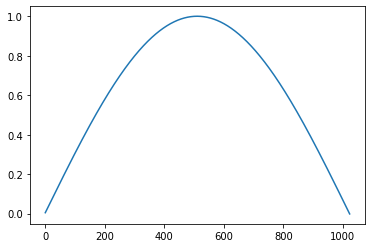

In [158]:
# The windown that we use
plt.plot(win)
plt.show()